## Task 1
## PLU Decomposition

- Prove that LU decomposition exists if and only if the matrix is strictly regular.
- Since not all matrices are strictly regular, it is necessary to perform row permutations so that the largest element by absolute value appears on the diagonal. This enhances the stability of the variable elimination procedure and the accumulation of triangular factors. Implement the algorithm for computing PLU decomposition. In doing so:
    - Column permutations are sufficient, but if you implement the algorithm for PLUQ decomposition, i.e., both rows and columns are permuted, you will receive bonus points.
    - The permutation and its inverse need to be stored as one-dimensional arrays. You will need to implement a function for incrementally updating the permutation after moving to the next diagonal element.
    - It is sufficient to use the maximum element by absolute value in the row as the pivot element.
    - Make the most possible use of NumPy's capabilities and eliminate loops where possible.
- Compare the result of your algorithm with the method from ```scipy.linalg``` for an ill-conditioned matrix. Plot the runtime of your algorithm as a function of the matrix size. Does the asymptotic behavior for PLU decomposition hold?

### 1.1. Prove that LU decomposition exists if and only if the matrix is strictly regular.

**Necessary Condition**

If there exists an $LU$ decomposition for matrix $A$, then it is regular.

Let $A_k, L_k, U_k$ denote the leading principal minors of the matrices $A, U, K$, respectively. Then we can represent the decomposition of $A$ as:

$$
A = \begin{bmatrix}
A_k & P \\
Q & \hat{A}_{k}
\end{bmatrix} = \begin{bmatrix}
L_k & 0 \\
V & \hat{L}_{k}
\end{bmatrix} \begin{bmatrix}
U_k & W \\
0 & \hat{U}_{k}
\end{bmatrix} \ \ \ (1).
$$

From equality (1), and due to the non-singularity of the matrices $L_k, U_k$ (triangular matrices with non-zero diagonal), it directly follows that the matrix $A_k$ is non-singular.

**Sufficient Condition**

If $A$ is strictly regular, then it has an $LU$ decomposition.

Suppose we have a decomposition for some leading minor $A_k = L_k U_k$. Then we have:

$$
\begin{bmatrix}
L_{k}^{-1} & 0 \\
-QA_{k}^{-1} & I
\end{bmatrix} \begin{bmatrix}
A_k & P \\
Q & \hat{A}_{k}
\end{bmatrix} = \begin{bmatrix}
U_k & L_{k}^{-1}P \\
0 & W
\end{bmatrix} \ \ \ (2)
$$

where $$W = \hat{A}_{k} - QA_{k}^{-1}P \ \ \ (3)$$

But since the matrix $A$ is strictly regular, from equality (3) the matrix $W$ is also strictly regular. Suppose we have a decomposition $W = \hat{L}_{k}\hat{U}_{k}$. Then we obtain the upper and lower triangular matrices $L, U$, which constitute the $LU$ decomposition of the original matrix.

$$
L = \begin{bmatrix}
L_k & 0 \\
-QA_{k}^{-1}L_k & I
\end{bmatrix}
\begin{bmatrix}
I & 0 \\
0 & \hat{L}_{k}
\end{bmatrix}, \quad U = \begin{bmatrix}
U_k & L_{k}^{-1}P \\
0 & \hat{U}_{k}
\end{bmatrix}.
$$


### 1.2. PLU implementation

In [3]:
import scipy.linalg
import numpy as np
import matplotlib.pyplot as plt
import time

In [6]:
def plu_decomposition(A):
    """
    Compute the PLU decomposition of the matrix A. The decomposition is A = P * L * U where P is a permutation matrix,
    L lower triangular with unit diagonal elements, and U upper triangular.

    !!! Note that P is initialized as an array, but this function returns matrix of permutations, this is needed for further tests and comparison.

    Parameters:
    A : The input matrix to decompose.

    Returns:
    P, L, U : Matrices P, L, and U such that A = P @ L @ U.
    """
    n = A.shape[0]
    L = np.zeros_like(A, dtype=np.double)
    U = np.zeros_like(A, dtype=np.double)
    P_array = np.arange(n)  # In the end we will make matrix out of the resulting array P
    A_copy = np.array(A, dtype=np.double)

    for i in range(n):
        # Permutation
        max_index = np.argmax(abs(A_copy[i:n, i])) + i
        if i != max_index:
            P_array[i], P_array[max_index] = P_array[max_index], P_array[i]
            A_copy[[i, max_index], :] = A_copy[[max_index, i], :]

        # Factors of L and U
        for j in range(i, n):
            U[i, j] = A_copy[i, j] - L[i, :i] @ U[:i, j]
        for j in range(i + 1, n):
            if U[i, i] == 0:
                raise ZeroDivisionError("Zero pivot, decomposition is impossible.")
            L[j, i] = (A_copy[j, i] - L[j, :i] @ U[:i, i]) / U[i, i]

    np.fill_diagonal(L, 1)

    # Expand P to matrix
    P = np.eye(n)[P_array]

    return P, L, U

In [7]:
# Test 1. Some random matrix
A_test = np.array([
    [3, 4, 7, 7, 7],
    [6, 8, 6, 3, 5],
    [4, 8, 9, 1, 2],
    [8, 10, 7, 5, 4],
    [2, 5, 2, 1, 10]
], dtype='float')

P_test, L_test, U_test = plu_decomposition(A_test)

# Verification
A_reconstructed_test = P_test @ L_test @ U_test
matches_test = np.allclose(A_reconstructed_test, A_test)

print(f"Is original matrix equiv to reconstructed ? : {matches_test}")

Is original matrix equiv to reconstructed ? : True


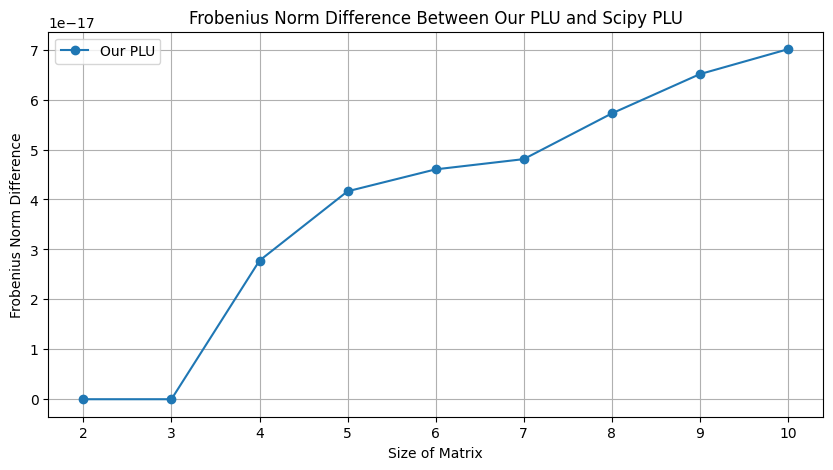

In [9]:
# Test 2. Hilbert matrix of different sizes

# Function to calculate Frobenius norm difference between our PLU reconstructed and original matrix
def frobenius_norm_diff(A, P, L, U):
    # Reconstruct A from PLU
    A_reconstructed = P @ L @ U
    diff_norm = np.linalg.norm(A - A_reconstructed, 'fro')
    return diff_norm

frobenius_norms_ours = []
sizes = range(2, 11)

for n in sizes:
    A = scipy.linalg.hilbert(n)
    P_ours, L_ours, U_ours = plu_decomposition(A)
    frobenius_norms_ours.append(frobenius_norm_diff(A, P_ours, L_ours, U_ours))

plt.figure(figsize=(10, 5))
plt.plot(sizes, frobenius_norms_ours, label='Our PLU', marker='o')
plt.xlabel('Size of Matrix')
plt.ylabel('Frobenius Norm Difference')
plt.title('Frobenius Norm Difference Between Our PLU and Scipy PLU')
plt.legend()
plt.grid(True)
plt.show()

### 1.3. Results comparison

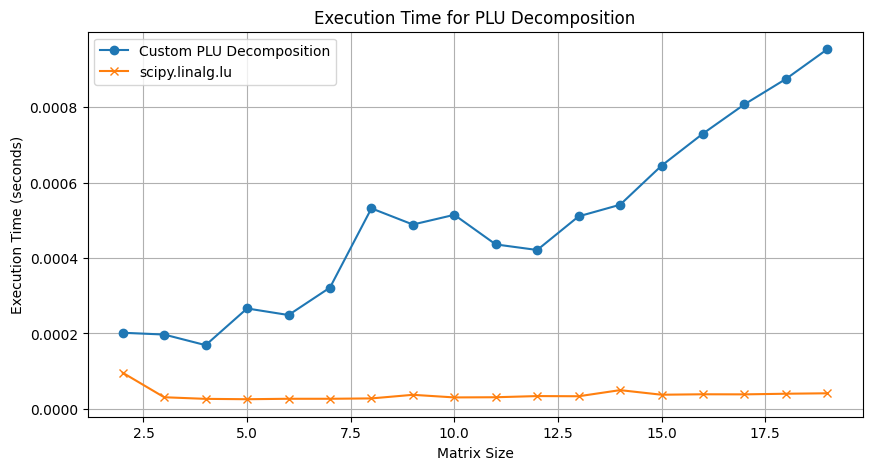

In [12]:
# Function to measure the execution time of PLU decomposition
def measure_time(matrix_size, method):
    A = scipy.linalg.hilbert(matrix_size)
    #print(np.linalg.cond(A,2))
    start_time = time.time()
    if method == "custom":
        _, _, _ = plu_decomposition(A)
    elif method == "scipy":
        _, _, _ = scipy.linalg.lu(A)
    end_time = time.time()

    return end_time - start_time

matrix_sizes = range(2, 20)
custom_times = [measure_time(size, "custom") for size in matrix_sizes]
scipy_times = [measure_time(size, "scipy") for size in matrix_sizes]

# Compare the performance
plt.figure(figsize=(10, 5))
plt.plot(matrix_sizes, custom_times, label='Custom PLU Decomposition', marker='o')
plt.plot(matrix_sizes, scipy_times, label='scipy.linalg.lu', marker='x')
plt.xlabel('Matrix Size')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time for PLU Decomposition')
plt.legend()
plt.grid(True)
plt.show()

## Anderson Acceleration

Many iterative methods in computational linear algebra can be written in the form of a fixed-point iteration:

$$ x_{k+1} = f(x_k), $$

so that the solution to the problem satisfies the condition $x^* = f(x^*)$. A sufficient condition for the convergence of such an iterative process for the function $f$ is its Lipschitz continuity with constant $L < 1$ and continuous differentiability in the vicinity of $x^*$ such that $|f'(x^*)| < L$.
There is quite a bit of theory surrounding iterations of this type, but we will be interested in a special way to accelerate the convergence of such an iterative process called **Anderson acceleration**.
The main idea of the method is to represent the next approximation as a linear combination of several previous values of the function $f$. More formally,

$$ x_{k+1} = \sum_{i=0}^{m-1} \alpha_i f(x_{k-m+i}), $$

where $m$ is the size of the history that needs to be stored and is set before the method starts, and $\alpha \in \mathbb{R}^n$ is found as the solution to the following optimization problem:

$$ \min_{\alpha} \| R\alpha\|_2, \quad \text{subject to} \quad \sum_{i=0}^{m-1} \alpha_i = 1, $$

where $R = [r_0, \ldots, r_{m-1}]$ and $r_i = f(x_i) - x_i$ are the residual vectors.
Note that for $m=1$, we obtain the original fixed-point iteration.

It should be noted that the problem of finding the coefficients $\alpha_i$ is very similar to the standard least squares problem, which can be solved using the function ```np.linalg.lstsq```, but there is an additional normalization constraint on the coefficients.

- Devise a way to equivalently transform the problem into a form that allows for a solution using the function ```np.linalg.lstsq```.
- Compare the obtained solution on random data (matrix $R$) with the solution to the original problem obtained using the function ```scipy.optimize.minimize```.

### Power Method
- Write the power method in the form of a fixed-point iteration. What is the function $f$?
- Implement Anderson acceleration for the power method using the approach to solving the auxiliary problem for the coefficients $\alpha$ obtained above. Compare the convergence of the standard and accelerated power methods in terms of time and number of iterations. Consider different values for the history size and analyze the influence of this hyperparameter on the convergence speed (in terms of time and number of iterations).


### 2.1. Anderson Acceleration Implementation

Introduce an additional vector $e = [1, 1, \ldots, 1]^T$ of dimension $m$, and add it to the matrix $R$ as a new row, forming the augmented matrix $\tilde{R}$. Thus, the matrix $\tilde{R}$ will have a size of $(m+1) \times m$. Now, it is necessary to minimize the norm $| \tilde{R}\alpha - b |_2$, where $b = [0, 0, \ldots, 0, 1]^T$ is a vector containing zeros and a one in the last position, corresponding to the constraint on the sum of $\alpha_i$.


In [1]:
from scipy.optimize import minimize
from numpy.linalg import norm

In [4]:
def minimize_sol(R):
    # Obj func
    def fun(alpha):
        return np.linalg.norm(R @ alpha, 2)

    initial_alpha = np.array([0,] * R.shape[1])
    # Constraint on sum
    constraints = ({'type': 'ineq', 'fun': lambda x: np.sum(x) - 1})
    res = minimize(fun, initial_alpha, method='SLSQP', constraints=constraints)

    return res.x

def lstsq_sol(R):
    R_augmented = np.vstack([R, np.ones(R.shape[1])])
    b_augmented = np.concatenate((np.zeros(R.shape[0]), [1]))
    alpha, _, _, _ = np.linalg.lstsq(R_augmented, b_augmented, rcond=None)

    return alpha

np.random.seed(239)
R = np.random.rand(20, 20)

alpha_scipy = minimize_sol(R)
alpha_lstsq = lstsq_sol(R)
alpha_lstsq /= np.sum(alpha_lstsq)
difference_l2 = np.linalg.norm(alpha_lstsq - alpha_scipy)

# Результаты
print(f'Solution obtained using scipy.optimize.minimize: {alpha_scipy}')
print(f'Custom solution via least squares: {alpha_lstsq}')
print(f'L2 norm of the difference between the solutions: {difference_l2}')

Solution obtained using scipy.optimize.minimize: [ 1.22069415 -0.15380098  4.47482123  0.80397151 -0.36397485  1.0934318
 -1.84914581  1.23105175 -0.45680708  0.27918053 -1.21634805 -0.55863237
  0.41679795 -0.44635115 -0.93310177 -4.03812483  1.15106699 -2.21916635
  1.78551357  0.77892375]
Custom solution via least squares: [ 1.22092086 -0.15432333  4.47459738  0.80365394 -0.36396699  1.09313918
 -1.84888916  1.23106538 -0.45661083  0.27901881 -1.21642263 -0.558736
  0.41692524 -0.44609349 -0.93263925 -4.03800266  1.15111582 -2.2192472
  1.78600724  0.77848771]
L2 norm of the difference between the solutions: 0.0012091755528364813


### 2.2. Power method

$y_{k+1} = A x_k$

$x_{k+1} = \frac{y_{k+1}}{\|y_{k+1}\|}$

Then f simplifies to: $$ f(x) = \frac{Ax}{\|Ax\|} $$

The final eigvec for power method : 0.03226504337459322
The final eigvec for Andersen-accelerated method method : 0.03226504337459321
The relative error between solutions : 2.1505918412529365e-14 %


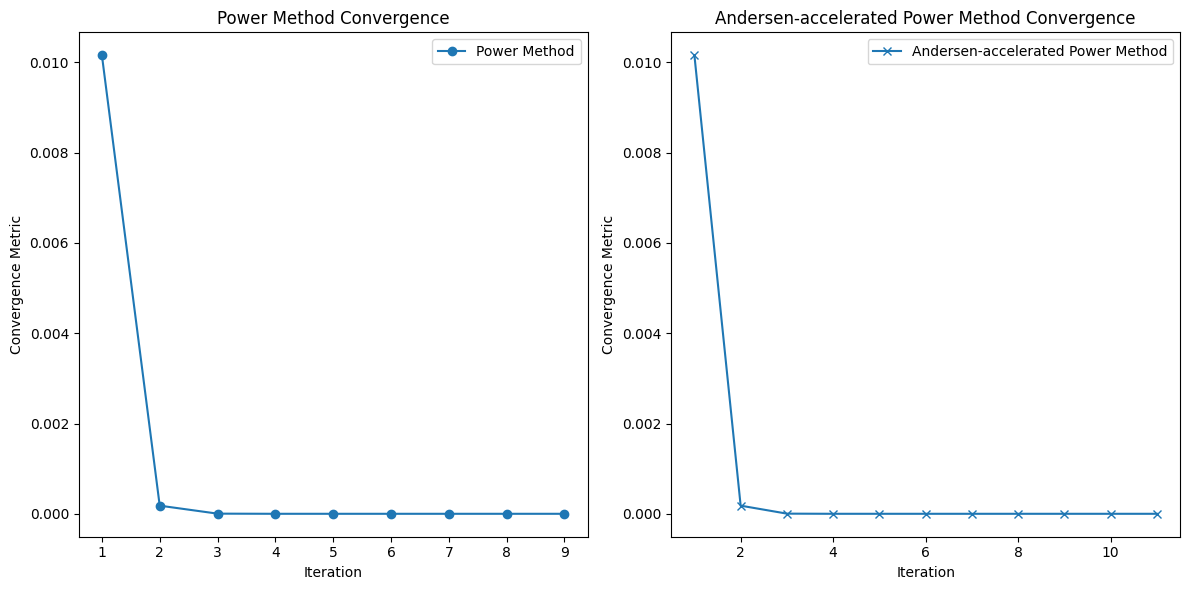

In [46]:
def andersen_acceleration(A, x0, max_iter, tol, m):
    x = x0
    X = np.zeros((len(x0), m + 1))
    convergence = []
    for k in range(max_iter):
        y = A @ x
        x_new = y / norm(y)

        # Store the new vector in the history matrix
        if k < m:
            X[:, k] = x_new
        else:
            X[:, 0:m-1] = X[:, 1:m]
            X[:, m-1] = x

            # Solve lstsq from previous task
            R = X - x_new[:, None]
            alphas = lstsq_sol(R)

            # Calculate the next iterate as a linear combination of the history vectors
            x_acc = X[:, :m] @ alphas[:-1]

            if norm(x_acc - x) < tol:  # Convergence condition
                break
            x = x_acc

        convergence.append(norm(x - x_new))
        x = x_new

    return x, convergence


def power_method(A, x0, max_iter, tol):
    x = x0
    convergence = []
    for _ in range(max_iter):
        y = A @ x
        x_new = y / norm(y)
        convergence.append(norm(x_new - x))
        if convergence[-1] < tol:
            break
        x = x_new
    return x, convergence

A = np.random.rand(1000, 1000)
x0 = np.random.rand(1000)
tol = 1e-15
max_iter = 10000

# We will test the influence of history size furhter, for the moment let's fix it at some value
history_size = 4

eigvec_power, conv_power = power_method(A, x0, max_iter, tol)
print(f"The final eigvec for power method : {eigvec_power[-1]}")
eigvec_acc, conv_acc = andersen_acceleration(A, x0, max_iter, tol, history_size)
print(f"The final eigvec for Andersen-accelerated method method : {eigvec_acc[-1]}")
relative_error = (eigvec_power[-1] - eigvec_acc[-1]) / eigvec_power[-1] * 100
print(f"The relative error between solutions : {relative_error} %")

# Skip some first points in convergence plot, since it causes an issue with scaling
skip_first_n = 1

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(skip_first_n, len(conv_power)), conv_power[skip_first_n:], label='Power Method', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Convergence Metric')
plt.title('Power Method Convergence')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(skip_first_n, len(conv_acc)), conv_acc[skip_first_n:], label='Andersen-accelerated Power Method', marker='x')
plt.xlabel('Iteration')
plt.ylabel('Convergence Metric')
plt.title('Andersen-accelerated Power Method Convergence')
plt.legend()

plt.tight_layout()
plt.show()

Compare these methods in terms of the number of iterations and the time required for convergence (depending on the size of the input matrix).

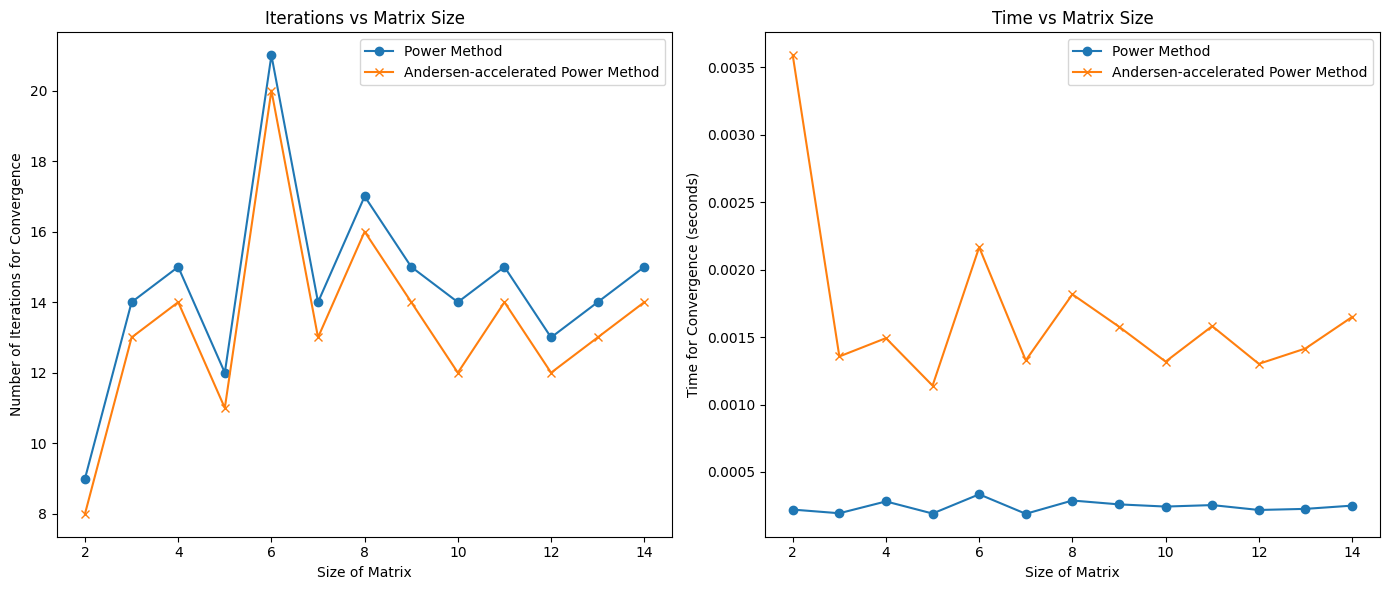

In [47]:
matrix_sizes = range(2, 15)

iterations_power = []
times_power = []
iterations_acc = []
times_acc = []

for size in matrix_sizes:
    A = np.random.rand(size, size)
    x0 = np.random.rand(size)
    max_iter = 1000
    tol = 1e-10

    # Store data for the power method
    start_time = time.time()
    _, conv_power = power_method(A, x0, max_iter, tol)
    end_time = time.time()
    times_power.append(end_time - start_time)
    iterations_power.append(len(conv_power))

    # Sore data for the Andersen-accelerated Power Method
    start_time = time.time()
    _, conv_acc = andersen_acceleration(A, x0, max_iter, tol, min(size, 4))
    end_time = time.time()
    times_acc.append(end_time - start_time)
    iterations_acc.append(len(conv_acc))

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(matrix_sizes, iterations_power, label='Power Method', marker='o')
plt.plot(matrix_sizes, iterations_acc, label='Andersen-accelerated Power Method', marker='x')
plt.xlabel('Size of Matrix')
plt.ylabel('Number of Iterations for Convergence')
plt.title('Iterations vs Matrix Size')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(matrix_sizes, times_power, label='Power Method', marker='o')
plt.plot(matrix_sizes, times_acc, label='Andersen-accelerated Power Method', marker='x')
plt.xlabel('Size of Matrix')
plt.ylabel('Time for Convergence (seconds)')
plt.title('Time vs Matrix Size')
plt.legend()

plt.tight_layout()
plt.show()

As seen from the graph on the left, the Anderson method requires <font color="green">fewer iterations</font> to achieve convergence. However, as shown in the graph on the right, it <font color="red">loses significantly in terms of time</font>.

Analyze the influence of the history size on the number of iterations and the convergence time.

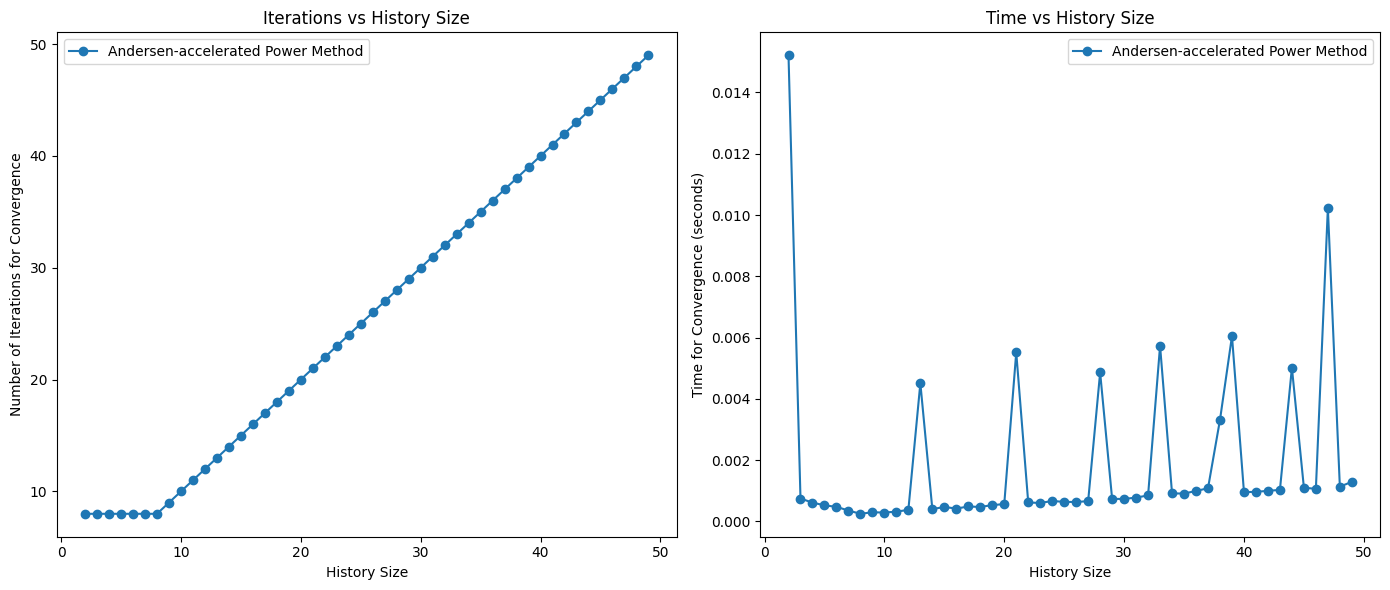

In [49]:
matrix_size = 100
A = np.random.rand(matrix_size, matrix_size)
x0 = np.random.rand(matrix_size)
max_iter = 1000
tol = 1e-10

history_sizes = range(2, 50)

iterations_for_history_sizes = []
times_for_history_sizes = []

for m in history_sizes:
    start_time = time.time()
    _, conv_acc = andersen_acceleration(A, x0, max_iter, tol, m)
    end_time = time.time()
    times_for_history_sizes.append(end_time - start_time)
    iterations_for_history_sizes.append(len(conv_acc))

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history_sizes, iterations_for_history_sizes, label='Andersen-accelerated Power Method', marker='o')
plt.xlabel('History Size')
plt.ylabel('Number of Iterations for Convergence')
plt.title('Iterations vs History Size')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_sizes, times_for_history_sizes, label='Andersen-accelerated Power Method', marker='o')
plt.xlabel('History Size')
plt.ylabel('Time for Convergence (seconds)')
plt.title('Time vs History Size')
plt.legend()

plt.tight_layout()
plt.show()

The number of iterations approximately linearly depends on the history size. If we exclude "outliers" from the graph on the right, we can notice that the time also changes almost linearly.